# Lab 3 — dimensionality reduction
**Internet Analytics - Lab 3**

---

**Group:** *K*

**Names:**

* *Robin Lang*
* *Kim Lan Phan Hoang*

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

relevance_file_name = "relevance_array.npy"

**construct ratings array** <br>
Using PySpark on the cluster, create the array containing all the ratings from `genome-scores.txt`

In [ ]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

In [10]:
n_movies = movies.map(lambda x: x["movieId"]).max()
n_tags = tags.map(lambda x: x["tagId"]).max()

In [11]:
print("movies:", n_movies, "| tags:", n_tags)

movies: 131262 | tags: 1128


In [12]:
relevance_array = np.zeros((n_tags, n_movies), dtype=float)

for i in data.toLocalIterator():
    relevance_array[i["tagId"]-1][i["movieId"]-1] = i["relevance"]

**save to file** <br>
Save the computed array to a file on disk

In [13]:
np.save(relevance_file_name, relevance_array)

**open existing array file** <br>
This allows us to use the previously done computations, so that we don't need to relaunch the expensive computation of the matrix, nor need the cluster, freeing up ressources for others

In [3]:
relevance_array = np.load(relevance_file_name)

n_movies = len(relevance_array[1])
n_tags = len(relevance_array)

## Exercice 3.1

### Plot the variance of each dimension / tag.

In [6]:
# compute the variance of each tag and save it into an array
rel_var = []
for i in relevance_array:
    rel_var.append(np.var(i))

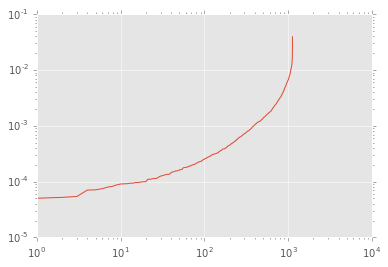

In [7]:
# plot the variances
# TODO title, plot unsorted ?
plt.loglog(sorted(rel_var))


### Plot the eigenvalues of the covariance matrix.

In [8]:
# compute covariance matrix
rel_cov = np.cov(relevance_array)
# the formula is:
#   rel_cov = 1/n_tags * relevance_array.T @ relevance_array
# which gives the same result as the above formula, but is way slower

# compute the eigenvalues and -vectors
rel_eigvals, rel_eigvecs = la.eigh(rel_cov)

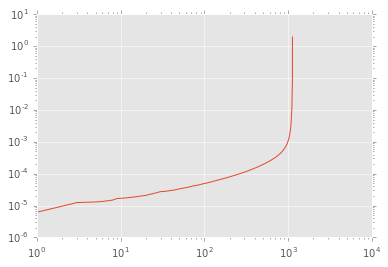

In [10]:
# plot the eigenvalues
plt.loglog(rel_eigvals)

### Explain the implications for dimensionality reduction.

Dimensionality reduction means you take some principal directions and project the data onto them. <br>
By doing this you effectively lose some precision, however the dimension of the data can often be greatly decreased, improving performance.

**How many principal directions do you need to capture $2 \over 3$ of the variability in the data?**

In [11]:
# TODO probably wrong, iunno
sum_eig = sum(rel_eigvals)
s = 0
n_eigvals = len(rel_eigvals)
index = 0

while s < sum_eig*2/3:
    s += rel_eigvals[n_eigvals-index-1]
    index += 1

print("to capture 2/3 of the variability you need", index, "principal directions")

to capture 2/3 of the variability you need 3 principal directions


## Exercice 3.2

### For the five first principal directions, find the 10 tags that have the highest and lowest coordinates in that direction.

In [29]:
# first 5 principle directions
# TODO not sure about formula...
rel_dirs = []
for i in range(5):
    rel_dirs.append(rel_cov @ rel_eigvecs[-i-1])
    # multiply by covariance matrix ?

In [30]:
def find_tags(tags, direction):
    N = len(tags)
    
    scores = np.zeros(N)

    for i in range(N):
        scores[i] = np.dot(tags[i], direction)
    
    # find indeces of 10 highest / lowest entries
    top10 = np.argsort(-scores)[:10]
    bottom10 = np.argsort(scores)[:10] # bottom 10 are always 0, as there are empty tags, where all entries are 0
    
    print("  top10:", top10+1)
    print("  bottom10:", bottom10+1)

In [31]:
count = ["1st", "2nd", "3rd", "4th", "5th"]

for i in range(5):
    print(count[i], "principal direction:")
    find_tags(relevance_array.T, rel_dirs[i])
    print("")

1st principal direction:
  top10: [   318   2571   2959 112582  27667  40697   4226     50 119139   4878]
  bottom10: [131262  84564  84563  84562  84561  84560  84559  84558  84557  84556]

2nd principal direction:
  top10: [ 8859 53996 36531 51520 60072 61348  5507 34150  7454  2617]
  bottom10: [ 5373  7767  3134  8125 26587  3089  6669  5147  6985  6611]

3rd principal direction:
  top10: [  2959    318   2571  27667   4226 112582     50  40697 119139   4878]
  bottom10: [131262  84707  84706  84705  84704  84703  84702  84701  84700  84699]

4th principal direction:
  top10: [ 27667   2571 119139 112582  40697    318   2959    260   1196   4226]
  bottom10: [131262  83946  83945  83944  83943  83942  83941  83940  83939  83938]

5th principal direction:
  top10: [131262  84682  84681  84680  84679  84678  84677  84676  84675  84674]
  bottom10: [   318   2571   2959  27667 112582  40697     50 119139   4226  25911]



### What concepts would you use to describe these dimensions?

WHAT??

## Exercice 3.3

### Create an interactive plot that displays the 2D-projection of the movies using bokeh and its hover tool. Color the nodes by their Rotten Tomatoes score.

In [32]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()
import pickle

Loading BokehJS ...

In [33]:
# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    
for movie in movies:
#    print(movie)
    pass

In [34]:
projected_x = [] # first principal direction
projected_y = [] # second principal direction

for i in movies:
    projected_x.append(np.dot(relevance_array.T[i[0]-1], rel_dirs[0]))
    projected_y.append(np.dot(relevance_array.T[i[0]-1], rel_dirs[1]))

In [35]:
# Continuous colors
from matplotlib.colors import rgb2hex 

# colors:   0% -> red
#          50% -> yellow
#         100% -> green
# interpolated in between
def rottenColor(val):
    if val<0.5:
        return rgb2hex([1.0, 2*val, 0.0])
    else:
        return rgb2hex([2*(1.0-val), 1.0, 0.0])

source = ColumnDataSource(
    data={
        "x": projected_x,
        "y": projected_y,
        "name": [x[1] for x in movies],
        "color": [rottenColor(x[2]) for x in movies],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=960, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=1.0)
show(p)

***PROBLEM: PRETTY SURE THAT'S SUPPOSED TO BE CENTERED AROUND 0***

### Explain the coordinates of a few of the movies.

The first principal direction is on the X direction, the second is on Y. A result close to 0 means that movie is perfectly represented by that principal direction. For example, "King's Speech" is very close to 0 on the Y axism which means that its tags are almost perfectly represented by that direction.

### How do the PCA directions correlate with the Rotten Tomatoes score?

iunno